In [3]:
import pandas as pd
import numpy as np

from warnings import filterwarnings
filterwarnings(action='ignore')

In [4]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
df = pd.DataFrame(data=housing['data'], columns=housing['feature_names'])
df['target'] = housing['target']
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers as L

@tf.keras.utils.register_keras_serializable()
def smish(x):
    return x * K.tanh(K.log(1 + K.sigmoid(x)))


@tf.keras.utils.register_keras_serializable()
class GatedLinearUnit(L.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.linear = L.Dense(units)
        self.sigmoid = L.Dense(units, activation="sigmoid")
        self.units = units

    def get_config(self):
        config = super().get_config()
        config['units'] = self.units
        return config
    
    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)
    

@tf.keras.utils.register_keras_serializable()
class GatedResidualNetwork(L.Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate
        self.relu_dense = L.Dense(units, activation=smish)
        self.linear_dense = L.Dense(units)
        self.dropout = L.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = L.LayerNormalization()
        self.project = L.Dense(units)

    def get_config(self):
        config = super().get_config()
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        return config
    
    def call(self, inputs):
        x = self.relu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x
    

@tf.keras.utils.register_keras_serializable()
class VariableSelection(L.Layer):
    def __init__(self, num_features, units, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.grns = list()
        # Create a GRN for each feature independently
        for idx in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        # Create a GRN for the concatenation of all the features
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = L.Dense(units=num_features, activation="softmax")
        self.num_features = num_features
        self.units = units
        self.dropout_rate = dropout_rate

    def get_config(self):
        config = super().get_config()
        config['num_features'] = self.num_features
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        return config
    
    def call(self, inputs):
        v = L.concatenate(inputs)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        x = []
        for idx, input_ in enumerate(inputs):
            x.append(self.grns[idx](input_))
        x = tf.stack(x, axis=1)

        outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
        return outputs
    

@tf.keras.utils.register_keras_serializable()
class VariableSelectionFlow(L.Layer):
    def __init__(self, num_features, units, dropout_rate, dense_units=None, **kwargs):
        super().__init__(**kwargs)
        self.variableselection = VariableSelection(num_features, units, dropout_rate)
        self.split = L.Lambda(lambda t: tf.split(t, num_features, axis=-1))
        self.dense = dense_units
        if dense_units:
            self.dense_list = [L.Dense(dense_units, \
                                       activation='linear') \
                               for _ in tf.range(num_features)
                              ]
        self.num_features = num_features
        self.units = units
        self.dropout_rate = dropout_rate
        self.dense_units = dense_units
        
    def get_config(self):
        config = super().get_config()
        config['num_features'] = self.num_features
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        config['dense_units'] = self.dense_units
        return config        
    
    def call(self, inputs):
        split_input = self.split(inputs)
        if self.dense:
            l = [self.dense_list[i](split_input[i]) for i in range(len(self.dense_list))]
        else:
            l = split_input
        return self.variableselection(l)

2023-08-21 23:03:11.988063: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from sklearn.model_selection import train_test_split

trainX, testX, trainy, testy = train_test_split(df.drop(columns=['target'], axis=1), df[['target']], random_state=42)

In [34]:
%%time
from sklearn.model_selection import KFold
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import Model
from tensorflow.keras import optimizers as O
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
blls = []

batch_size = 1000#32

units_1 = 32
drop_1 = 0.75
dense_units = 8

units_2 = 16
drop_2 = 0.5

units_3 = 8
drop_3 = 0.25

cv = KFold(n_splits=5, shuffle=True, random_state=42)#StratifiedKFold(n_splits=5, shuffle=True, random_state=722)
X = trainX.reset_index(drop=True).values
y = trainy.reset_index(drop=True).values
for n, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    for k in range(3):
        print(f'______fold {n+1}______, ________repeat {k+1}__________')
        inputs_1 = tf.keras.Input(shape=(trainX.shape[1],))
        
        features_1 = VariableSelectionFlow(trainX.shape[1], units_1, drop_1, dense_units=dense_units)(inputs_1)
        features_2 = VariableSelectionFlow(units_1, units_2, drop_2)(features_1)         
        features_3 = VariableSelectionFlow(units_2, units_3, drop_3)(features_2)         

        outputs = L.Dense(1)(features_3)

        model = Model(inputs=inputs_1, outputs=outputs)      

        opt = O.Adam(1e-3, epsilon=1e-7)
        loss = MeanSquaredError()

        lr = ReduceLROnPlateau(monitor="val_loss", mode='min', factor=0.95, patience=1, verbose=1)
        es = EarlyStopping(monitor='val_loss', mode='min', patience=25, verbose=1, restore_best_weights=True)

        model.compile(optimizer=opt, loss=loss)
        history = model.fit(x=X[train_idx], y=y[train_idx],
                          batch_size=batch_size,
                          epochs=100,
                          validation_data=(X[val_idx], y[val_idx]),
                          callbacks=[lr, es])
                
        bll = loss(y[val_idx], model.predict(X[val_idx]))
        blls.append(bll)
        val_loss = np.asarray(history.history['val_loss'])
        train_loss = np.asarray(history.history['loss'])
        min_val_loss = val_loss.min()
        min_train_loss = train_loss[val_loss.argmin()]
        print(f'min_train_loss: {min_train_loss:.4f}, min_val_loss: {min_val_loss:.4f}, bll: {bll:.4f}')  
        
        #model.save_weights(f'./models_weights/mod_f{n}_r{k}.h5')
        
print(np.mean(blls))

______fold 1______, ________repeat 1__________


Epoch 1/100
13/13 [==============================] - 258s 1s/step - loss: 2.5957 - val_loss: 1.4050 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 3s 254ms/step - loss: 1.3945 - val_loss: 1.3282 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 1.3377
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
13/13 [==============================] - 3s 214ms/step - loss: 1.3377 - val_loss: 1.3472 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 1.3385
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009025000152178108.
13/13 [==============================] - 3s 232ms/step - loss: 1.3385 - val_loss: 1.3356 - lr: 9.5000e-04
Epoch 5/100
13/13 [==============================] - 3s 215ms/step - loss: 1.3360 - val_loss: 1.3266 - lr: 9.0250e-04
Epoch 6/100
13/13 [==============================] - 3s 226ms/step - loss: 1.3293 - val_loss: 1.3211 - lr: 9.0250e-04
Epoch 7/100
13/13 [======

KeyboardInterrupt: 

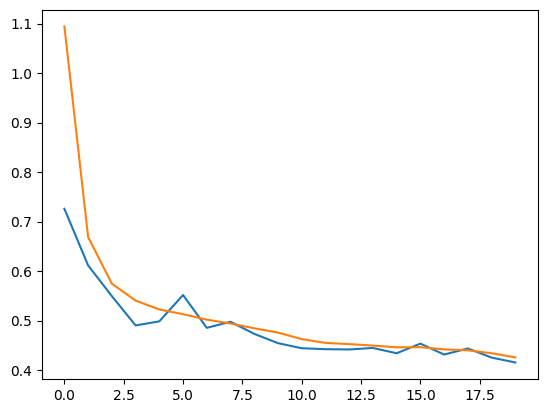

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(val_loss)
plt.plot(train_loss)
plt.show()

In [7]:
import os
import re
mfolder = './'
models_weights = os.listdir(mfolder)
r = re.compile(".*h5")
models_weights = list(filter(r.match, models_weights))

In [9]:
y_pred = np.zeros_like(testy.iloc[:,0].values, dtype=np.float32)
batch_size = 32

units_1 = 32
drop_1 = 0.75
dense_units = 8

units_2 = 16
drop_2 = 0.5

units_3 = 8
drop_3 = 0.25
predys = [[0]*len(testX) for _ in range(len(models_weights))]

for n, model_weights in enumerate(models_weights):
    inputs_1 = tf.keras.Input(shape=(testX.shape[1],))
    
    features_1 = VariableSelectionFlow(testX.shape[1], units_1, drop_1, dense_units=dense_units)(inputs_1)
    features_2 = VariableSelectionFlow(units_1, units_2, drop_2)(features_1)
    features_3 = VariableSelectionFlow(units_2, units_3, drop_3)(features_2)

    outputs = L.Dense(1)(features_3)

    model = Model(inputs=inputs_1, outputs=outputs)
    model.load_weights(mfolder + model_weights)
    predys[n] = model.predict(testX)

162/162 [==============================] - 12s 22ms/step


In [12]:
predy = np.median(predys, axis=0).ravel()


In [13]:
from sklearn.metrics import mean_squared_error
mean_squared_error(testy, predy)

0.4144616452839398